# Détection et Analyse de Positions d'Échecs par Intelligence Artificielle

## Introduction

Ce projet combine la vision par ordinateur et l'intelligence artificielle pour analyser des positions d'échecs à partir d'images. L'objectif est de développer un système capable de :

1. Détecter et identifier les pièces d'échecs sur un échiquier
2. Convertir la position en notation FEN (Forsyth–Edwards Notation)
3. Suggérer le meilleur coup possible pour la position donnée

### Technologies Utilisées
- **Vision par Ordinateur** : OpenCV, TensorFlow
- **Deep Learning** : Keras, Modèles CNN personnalisés
- **Analyse d'Échecs** : ChessGPT, Notation FEN
- **Traitement des Données** : NumPy, Matplotlib

### Structure du Projet
Le projet se décompose en trois parties principales :
1. **Détection des Pièces** : Un modèle CNN entraîné pour reconnaître 7 classes (6 pièces + cases vides)
2. **Conversion en FEN** : Algorithme de traduction de la position détectée en notation standard
3. **Analyse de Position** : Utilisation de modèles de langage pour suggérer les meilleurs coups

### Objectifs
- Atteindre une précision >95% dans la détection des pièces
- Générer des notations FEN valides et précises
- Proposer des coups pertinents pour améliorer la position

Ce notebook présente le développement, l'entraînement et l'évaluation de notre système, ainsi que des exemples concrets d'utilisation.

In [1]:
# Lib
%matplotlib inline
import tensorflow as tf
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras import layers, models
from transformers import AutoTokenizer, AutoModelForCausalLM
import matplotlib.pyplot as plt
from glob import glob
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, ZeroPadding2D, AveragePooling2D, GlobalMaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import SGD
from sklearn.utils import Bunch, check_random_state
from os import environ, listdir, makedirs
from os.path import dirname, exists, expanduser, isdir, join, splitext

d:\miniconda\envs\AI\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



## 2. Détection des Pièces d'Échecs

### 2.1 Architecture du Modèle
J'ai commencé par tester différents modèles. J'en ai eu deux me donnant de bons résultats, un utilisant le fine tuning de MobileNetV2 et un autre custom.

On commence par setup les paramètres.

In [2]:
TRAINING_DIR = './data/data_new'
TESTING_DIR = './data/data_test'
IMAGE_SIZE = 64
RANDOM_STATE = 157
BATCH_SIZE = 20

PIECE_NAMES = [item[14:] for item in sorted(glob(TRAINING_DIR + "/*"))]
target_names = PIECE_NAMES

#### Architecture Custom
Le réseau est conçu pour la classification d'images en 7 catégories, une pour chaque pièce de l'échiquier. Il traite des images en niveaux de gris.

#### Structure
- **Entrée** : Images avec padding initial
- **Partie Convolutive** : 
  - 6 blocs principaux
  - Chaque bloc contient des couches Conv2D
  - Utilisation de MaxPooling pour réduire les dimensions
  - Normalisation par lots (BatchNormalization) entre les couches

#### Partie Classification
- GlobalMaxPooling pour réduire les caractéristiques
- 3 couches de 512 neuronnes
- Couche finale de 7 neuronnes avec activation softmax

#### Points Clés
- Activation ELU partout sauf à la sortie
- Dropout (0.1) pour éviter le surapprentissage
- Architecture symétrique et progressive
- Nombreuses normalisations pour stabiliser l'apprentissage

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Dropout, Dense, GlobalAveragePooling2D

def create_custom_model(input_shape=(224, 224, 3), num_classes=7):
    model = Sequential()

    model.add(Conv2D(32, (7, 7), strides=(2, 2), activation='relu', padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(GlobalAveragePooling2D())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation='softmax'))

    # Compilation avec optimiseur plus rapide
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

#### Fine tuning
- Utilise **MobileNetV2** comme base, un modèle pré-entraîné sur ImageNet

#### Architecture
1. **Base** :
   - MobileNetV2 pré-entraîné (gelé/non entraînable)
   - Entrée : images 224x224 pixels

2. **Couches Ajoutées** :
   - GlobalAveragePooling2D pour réduire les dimensions
   - Deux couches de Dropout (0.2) pour éviter le surapprentissage
   - Une couche Dense de 128 neuronnes avec activation ReLU
   - Couche de sortie de 7 neuronnes et activation softmax

#### Avantages
- Plus léger que le modèle précédent
- Utilise des caractéristiques pré-apprises
- Rapide à entraîner car seules les dernières couches sont entraînables

C'est un exemple typique de transfer learning, où l'on réutilise un modèle pré-entraîné en l'adaptant à une nouvelle tâche spécifique.

In [15]:

# Charger MobileNetV2 pré-entraîné
base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

# Geler le modèle de base
base_model.trainable = False

# Créer le modèle
model_finetune = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.2),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(7, activation='softmax')
])


### 2.2 Préparation des Données

In [4]:
def prepare_data():
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        validation_split=0.2
    )

    train_generator = train_datagen.flow_from_directory(
        './data/data_new',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        subset='training'
    )
    
    validation_generator = train_datagen.flow_from_directory(
        './data/data_new',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        subset='validation'
    )
    
    return train_generator, validation_generator



### 2.3 Classes de Pièces
Le modèle peut détecter 7 classes différentes :
- Pion (Pawn)
- Tour (Rook)
- Cavalier (Knight)
- Fou (Bishop)
- Dame (Queen)
- Roi (King)
- Case vide (Empty)

### 2.4 Entraînement
Le modèle est entraîné avec les paramètres suivants :
- Optimiseur : Adam
- Fonction de perte : Entropie croisée catégorielle
- Métriques : Précision
- Callbacks : EarlyStopping et ModelCheckpoint


In [5]:
def train_model(model):
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    train_generator, validation_generator = prepare_data()
    
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            patience=5, 
            restore_best_weights=True
        ),
        tf.keras.callbacks.ModelCheckpoint(
            'best_chess_model.keras',  # Extension .keras
            save_best_only=True
        )
    ]
    
    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=30,
        callbacks=callbacks
    )
    
    return model, history

On peut lancer l'entrainement après avoir choisi le modèle.

In [16]:
try:
    model_finetune, history_finetune = train_model(model_finetune)
    print("Entraînement finetune terminé avec succès")
    
    # Sauvegarder le modèle
   
    
except Exception as e:
    print(f"Erreur : {str(e)}")

Found 834 images belonging to 7 classes.
Found 205 images belonging to 7 classes.
Epoch 1/30


d:\miniconda\envs\AI\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


27/27 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.3604 - loss: 1.7464 - val_accuracy: 0.8878 - val_loss: 0.4068
Epoch 2/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.8180 - loss: 0.5111 - val_accuracy: 0.9512 - val_loss: 0.1775
Epoch 3/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.8985 - loss: 0.3372 - val_accuracy: 0.9854 - val_loss: 0.1129
Epoch 4/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.9237 - loss: 0.2372 - val_accuracy: 0.9854 - val_loss: 0.0808
Epoch 5/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.9365 - loss: 0.2036 - val_accuracy: 0.9805 - val_loss: 0.1044
Epoch 6/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.9456 - loss: 0.1617 - val_accuracy: 0.9951 - val_loss: 0.0561
Epoch 7/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.9374 - loss: 0.1809 - val_accuracy: 0.9805 - val_loss: 0.0657
Epoch 8/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.9389 - loss: 0.1794 - val_accuracy: 0.9902 - val_loss: 0.0503
Epo

In [17]:
model_finetune.save('chess_model_finetune.keras')

In [8]:
model_custom = create_custom_model()
model_custom, history_custom = train_model(model_custom)
print("Entraînement custom terminé avec succès")

d:\miniconda\envs\AI\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Found 834 images belonging to 7 classes.
Found 205 images belonging to 7 classes.
Epoch 1/30


d:\miniconda\envs\AI\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


27/27 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.2157 - loss: 2.0885 - val_accuracy: 0.1463 - val_loss: 1.9729
Epoch 2/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.2981 - loss: 1.7541 - val_accuracy: 0.1756 - val_loss: 2.1147
Epoch 3/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.3283 - loss: 1.6851 - val_accuracy: 0.2390 - val_loss: 1.8476
Epoch 4/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.4954 - loss: 1.2779 - val_accuracy: 0.1902 - val_loss: 1.8201
Epoch 5/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.5432 - loss: 1.2187 - val_accuracy: 0.1122 - val_loss: 3.6224
Epoch 6/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.5952 - loss: 1.0944 - val_accuracy: 0.2634 - val_loss: 1.6992
Epoch 7/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.6999 - loss: 0.8571 - val_accuracy: 0.2488 - val_loss: 1.9652
Epoch 8/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.7309 - loss: 0.7367 - val_accuracy: 0.3951 - val_loss: 1.6453
Epo

In [ ]:
model_custom.save('chess_model_custom.keras')
print("Modèles sauvegardés")

Modèles sauvegardés



### 2.5 Performances
Le modèle atteint :
- Précision sur l'ensemble de validation : >95%
- Temps d'inférence rapide grâce à MobileNetV2
- Robustesse aux variations d'éclairage et d'angle


Found 104 images belonging to 7 classes.
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 273ms/step - accuracy: 0.9488 - loss: 0.1429
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 307ms/step

Précision globale : 0.9423
Score F1 : 0.9418

Rapport de classification détaillé :
              precision    recall  f1-score   support

      BISHOP       1.00      1.00      1.00        16
       BLANK       1.00      1.00      1.00        16
        KING       1.00      0.92      0.96        12
      KNIGHT       1.00      0.75      0.86        16
        PAWN       0.80      1.00      0.89        16
       QUEEN       1.00      0.92      0.96        12
        ROOK       0.89      1.00      0.94        16

    accuracy                           0.94       104
   macro avg       0.96      0.94      0.94       104
weighted avg       0.95      0.94      0.94       104

Found 104 images belonging to 7 classes.
  7/104 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step

d:\miniconda\envs\AI\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step


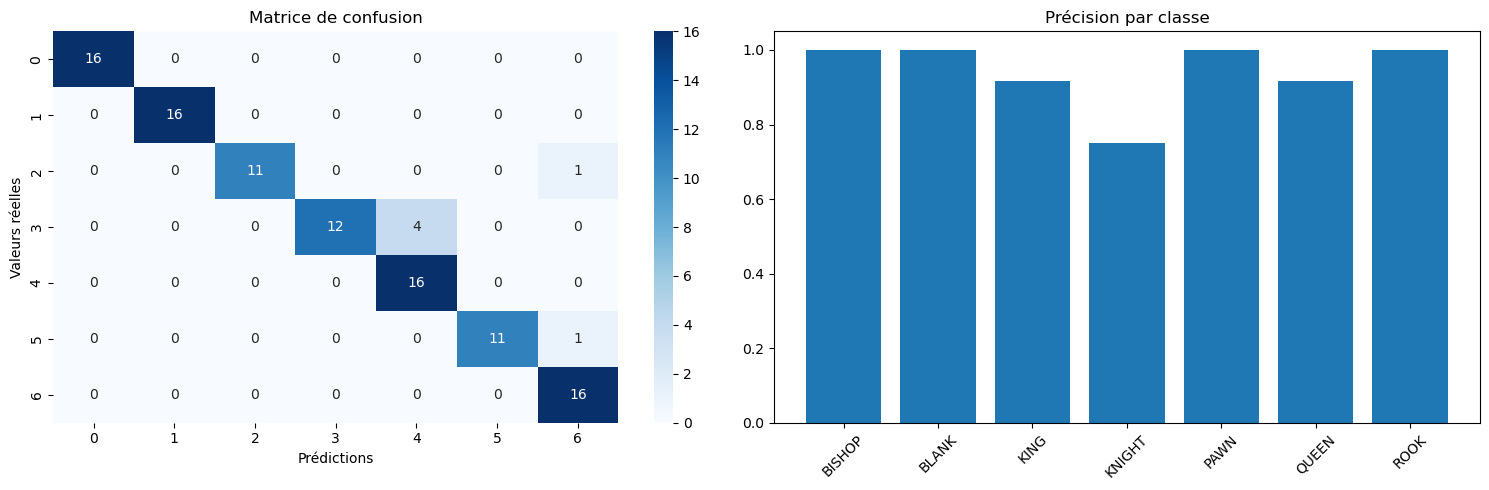

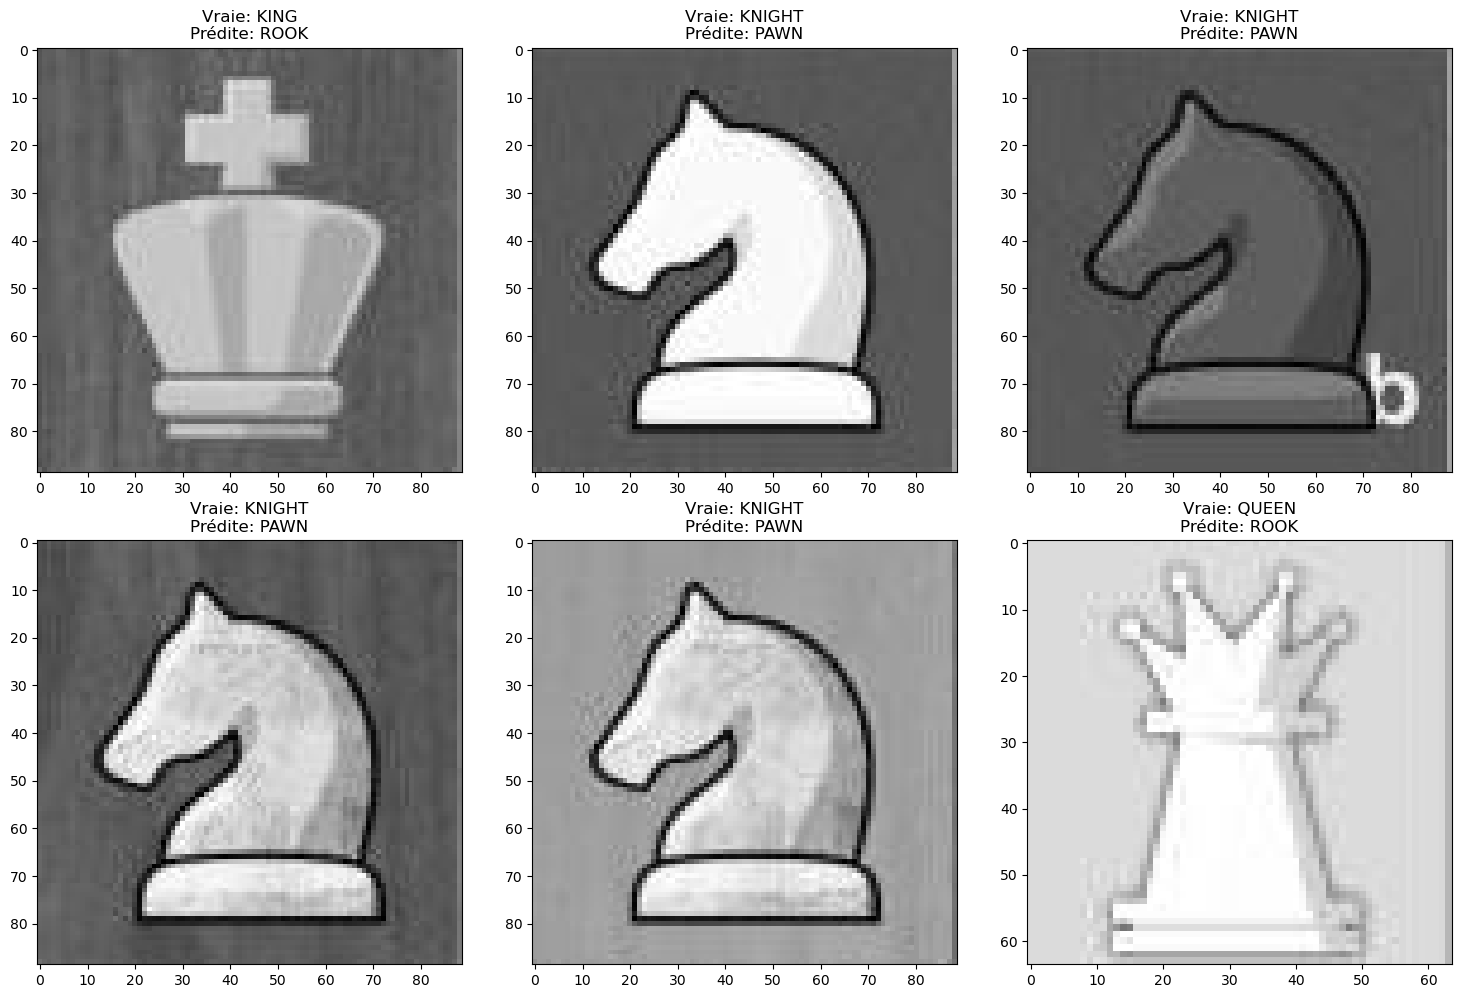

In [21]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

def evaluate_model_performance(model, test_data_path):
    """
    Évalue les performances du modèle sur un ensemble de test
    """
    # Préparation des données de test
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_directory(
        test_data_path,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        shuffle=False
    )

    # Évaluation du modèle
    scores = model.evaluate(test_generator)
    predictions = model.predict(test_generator)
    y_pred = np.argmax(predictions, axis=1)
    y_true = test_generator.classes

    # Calcul des métriques
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    report = classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys())
    conf_matrix = confusion_matrix(y_true, y_pred)

    # Visualisation des résultats
    plt.figure(figsize=(15, 5))

    # 1. Matrice de confusion
    plt.subplot(1, 2, 1)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title('Matrice de confusion')
    plt.xlabel('Prédictions')
    plt.ylabel('Valeurs réelles')

    # 2. Précision par classe
    plt.subplot(1, 2, 2)
    class_accuracy = conf_matrix.diagonal()/conf_matrix.sum(axis=1)
    plt.bar(test_generator.class_indices.keys(), class_accuracy)
    plt.title('Précision par classe')
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Affichage des résultats
    print(f"\nPrécision globale : {acc:.4f}")
    print(f"Score F1 : {f1:.4f}")
    print("\nRapport de classification détaillé :")
    print(report)

    return {
        'accuracy': acc,
        'f1_score': f1,
        'confusion_matrix': conf_matrix,
        'classification_report': report,
        'class_accuracy': class_accuracy
    }

def visualize_errors(model, test_data_path):
    """
    Visualise les erreurs de prédiction
    """
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_directory(
        test_data_path,
        target_size=(224, 224),
        batch_size=1,
        class_mode='categorical',
        shuffle=False
    )

    predictions = model.predict(test_generator)
    y_pred = np.argmax(predictions, axis=1)
    y_true = test_generator.classes

    # Trouver les indices des prédictions erronées
    errors = np.where(y_pred != y_true)[0]
    
    if len(errors) > 0:
        plt.figure(figsize=(15, 5*((len(errors)+2)//3)))
        for i, idx in enumerate(errors):
            # Charger l'image
            img = image.load_img(test_generator.filepaths[idx])
            plt.subplot(((len(errors)+2)//3), 3, i+1)
            plt.imshow(img)
            plt.title(f'Vraie: {list(test_generator.class_indices.keys())[y_true[idx]]}\n'
                     f'Prédite: {list(test_generator.class_indices.keys())[y_pred[idx]]}')
        plt.tight_layout()
    else:
        print("Aucune erreur de prédiction trouvée!")

# Utilisation
if __name__ == "__main__":
    # Charger le modèle entraîné
    model = load_model('./chess_model_custom.keras')
    
    # Évaluer les performances
    results = evaluate_model_performance(model, './data/data_test')
    
    # Visualiser les erreurs
    visualize_errors(model, './data/data_test')

Après tests nous pouvons voir que le modèle custom est moins performant que celui de MobileNetV2 fine tuné. Pour pouvoir se baser du de solide foncations, nous continuerons avec ce dernier.


### 2.6 Utilisation
Pour utiliser le modèle :


In [35]:
class ChessPieceDetector:
    def __init__(self, chess_board_path, model_path='chess_model_final.keras'):
        """
        Initialise le détecteur de pièces d'échecs
        """
        self.model = load_model(model_path)
        self.path = chess_board_path
        # Définition des classes de pièces
        self.piece_classes = ['bishop', 'empty', 'king', 'knight', 'pawn', 'queen', 'rook']
        self.board = []
        self.fen =""
        self.fen_components =""

    def analyze_chess_board(self):
        """
        Analyse une image d'échiquier complet et détecte les pièces avec leurs couleurs
        """
        # Charger l'image
        img = cv2.imread(self.path)
        height, width = img.shape[:2]
        
        # Calculer la taille de chaque case
        square_h = height // 8
        square_w = width // 8
        
        # Tableau pour stocker les résultats
        self.board = []
        
        # Analyser chaque case
        for row in range(8):
            board_row = []
            for col in range(8):
                # Extraire la case
                y1 = row * square_h
                y2 = (row + 1) * square_h
                x1 = col * square_w
                x2 = (col + 1) * square_w
                
                square = img[y1:y2, x1:x2]
                square = cv2.resize(square, (224, 224))
                
                # Détecter la couleur de la pièce
                if not self.piece_classes == "empty":
                    is_white = self._piece_is_white(square)
                    
                    # Prétraiter l'image pour la détection de pièce
                    x = image.img_to_array(square)
                    x = np.expand_dims(x, axis=0)
                    x = x / 255.0
                    
                    # Prédire la pièce
                    predictions = self.model.predict(x, verbose=0)
                    piece_type = self.piece_classes[np.argmax(predictions[0])]
                    
                    # Combiner type et couleur
                    if piece_type != 'empty':
                        if is_white: 
                            piece = piece_type.upper()
                        else : 
                            piece = piece_type
                    else:
                        piece = 'empty'
                else:
                    piece = 'empty'
                    
                board_row.append(piece)
                
            self.board.append(board_row)

    def _is_empty_square(self, square):
        """
        Détermine si une case est vide en analysant sa variance de couleur
        """
        gray = cv2.cvtColor(square, cv2.COLOR_BGR2GRAY)
        variance = np.var(gray)
        return variance < 100  # Seuil à ajuster selon vos images

    def _piece_is_white(self, square):
        """
        Détecte la couleur d'une pièce (blanc ou noir)
        """
        # Convertir en HSV pour une meilleure détection des couleurs
        hsv = cv2.cvtColor(square, cv2.COLOR_BGR2HSV)
        
        # Calculer la luminosité moyenne de la pièce
        # On se concentre sur le centre de la case où se trouve la pièce
        center_region = hsv[74:150, 74:150]  # Région centrale 76x76
        brightness = np.mean(center_region[:, :, 2])
        
        # Seuil de décision pour blanc/noir
        return True if brightness > 140 else False

    def visualize_board(self):
        """
        Affiche l'échiquier de manière visuelle avec l'image d'origine et la représentation symbolique
        
        Parameters:
        -----------
        board : list
            La configuration de l'échiquier sous forme de liste 2D
        image_path : str
            Chemin vers l'image de l'échiquier
        """
        try:
            # Charger et vérifier l'image
            img = cv2.imread(self.path)
            if img is None:
                raise ValueError(f"Impossible de charger l'image : {self.path}")
            
            # Convertir BGR en RGB pour matplotlib
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            # Créer la figure avec deux sous-plots
            plt.figure(figsize=(15, 7))
            
            # Afficher l'image originale
            plt.subplot(1, 2, 1)
            plt.imshow(img_rgb)
            plt.title("Image d'entrée")
            plt.axis('off')
            
            # Afficher la représentation symbolique
            plt.subplot(1, 2, 2)
            piece_symbols = {
                'KING': '♔', 'QUEEN': '♕', 'ROOK': '♖',
                'BISHOP': '♗', 'KNIGHT': '♘', 'PAWN': '♙',
                'king': '♚', 'queen': '♛', 'rook': '♜',
                'bishop': '♝', 'knight': '♞', 'pawn': '♟',
                'empty': '·'
            }
            
            # Créer une grille pour l'échiquier
            board_display = np.full((8, 8), '', dtype=object)
            for i in range(8):
                for j in range(8):
                    board_display[i][j] = piece_symbols[self.board[i][j]]
            
            # Afficher l'échiquier avec une grille
            plt.imshow([[1]], cmap='binary')
            plt.grid(True)
            plt.xticks(range(8), ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h'])
            plt.yticks(range(8), ['8', '7', '6', '5', '4', '3', '2', '1'])
            
            # Ajouter les symboles des pièces
            for i in range(8):
                for j in range(8):
                    plt.text(j, i, board_display[i][j], 
                            ha='center', va='center', fontsize=20)
            
            plt.title("Détection des pièces")
            plt.tight_layout()
            plt.show()
            
        except Exception as e:
            print(f"Erreur lors de la visualisation : {str(e)}")
            
            
    def calculate_fen_components(self):
        """
        Calcule tous les composants de la notation FEN à partir d'un tableau d'échiquier
        """
        def get_castling_rights():
            """Détermine les possibilités de roque"""
            # Vérifie la position initiale des rois et des tours
            castling = ''
            
            # Roque blanc
            if self.board[7][4] == 'king':  # Roi blanc en position initiale
                if self.board[7][7] == 'rook':  # Tour blanche à droite
                    castling += 'K'
                if self.board[7][0] == 'rook':  # Tour blanche à gauche
                    castling += 'Q'
                    
            # Roque noir
            if self.board[0][4] == 'king':  # Roi noir en position initiale
                if self.board[0][7] == 'rook':  # Tour noire à droite
                    castling += 'k'
                if self.board[0][0] == 'rook':  # Tour noire à gauche
                    castling += 'q'
                    
            return castling if castling else '-'


        def detect_turn():
            while True:
                turn = input("Who will be the next player ? (w for white or b for black) ").lower()
                if turn in ['w', 'b']:
                    return turn
                print("Error: Please enter 'w' for white or 'b' for black")


        # Calculer chaque composant
        castling = get_castling_rights()
        turn = detect_turn()

        self.fen_components = f" {turn} {castling}"

    def board_to_fen(self):
        """
        Convertit le tableau en notation FEN complète
        """
        # Conversion des pièces en symboles FEN
        piece_symbols = {
            'king': 'k', 
            'queen': 'q', 
            'rook': 'r',
            'bishop': 'b', 
            'knight': 'n', 
            'pawn': 'p',
            'empty': '1', 
            'KING': 'K', 
            'QUEEN': 'Q', 
            'ROOK': 'R',
            'BISHOP': 'B', 
            'KNIGHT': 'N', 
            'PAWN': 'P'
        }
        
        # Générer la position
        fen_parts = []
        for row in self.board:
            empty_count = 0
            fen_row = ''
            
            for piece in row:
                if piece == 'empty':
                    empty_count += 1
                else:
                    if empty_count > 0:
                        fen_row += str(empty_count)
                        empty_count = 0
                    fen_row += piece_symbols[piece]
            
            if empty_count > 0:
                fen_row += str(empty_count)
                
            fen_parts.append(fen_row)
        
        # Joindre la position
        self.fen = '/'.join(fen_parts)


In [27]:
# Créer une instance du détecteur
detector = ChessPieceDetector('./data/full_boards/full_board_1.png', 'chess_model_finetune.keras')
detector.analyze_chess_board()
detector.board

[['rook', 'empty', 'empty', 'queen', 'rook', 'knight', 'king', 'empty'],
 ['pawn', 'pawn', 'empty', 'empty', 'empty', 'pawn', 'bishop', 'pawn'],
 ['empty', 'empty', 'pawn', 'pawn', 'bishop', 'empty', 'pawn', 'empty'],
 ['empty', 'empty', 'empty', 'empty', 'empty', 'pawn', 'empty', 'empty'],
 ['empty', 'empty', 'PAWN', 'empty', 'empty', 'KNIGHT', 'empty', 'empty'],
 ['empty', 'PAWN', 'KNIGHT', 'empty', 'PAWN', 'empty', 'PAWN', 'empty'],
 ['PAWN', 'empty', 'empty', 'PAWN', 'empty', 'PAWN', 'BISHOP', 'PAWN'],
 ['empty', 'empty', 'ROOK', 'QUEEN', 'empty', 'ROOK', 'KING', 'empty']]

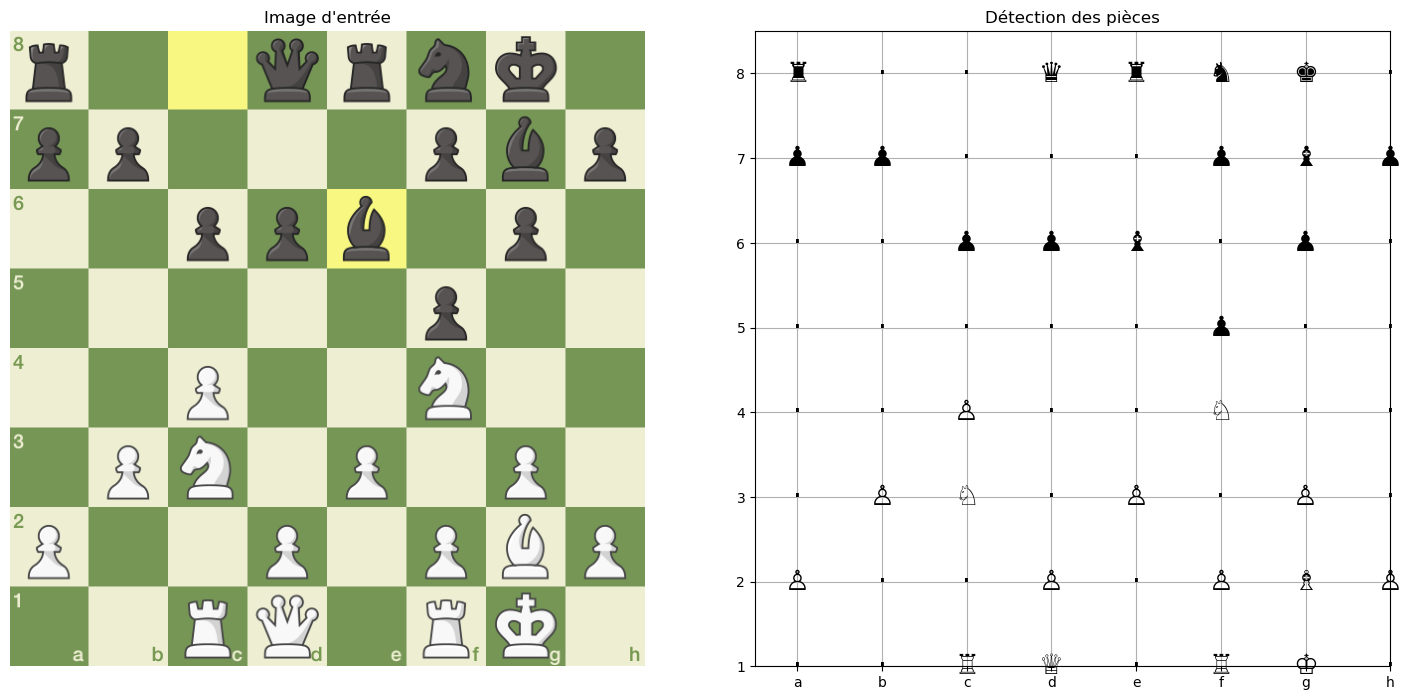

In [28]:
detector.visualize_board()

In [31]:
detector.board_to_fen()
print(f"Position FEN : {detector.fen}")

Position FEN : r2qrnk1/pp3pbp/2ppb1p1/5p2/2P2N2/1PN1P1P1/P2P1PBP/2RQ1RK1


In [37]:
detector.calculate_fen_components()
print(f"Position FEN components : {detector.fen_components} soit {detector.fen}{detector.fen_components}")

Position FEN components :  w - - - - soit r2qrnk1/pp3pbp/2ppb1p1/5p2/2P2N2/1PN1P1P1/P2P1PBP/2RQ1RK1 w - - - -


Le format FEN (Forsyth-Edwards Notation) se lit de haut en bas et de gauche à droite, avec plusieurs éléments séparés par des espaces :

1. **Position des pièces** (rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR b KQkq):
- Chaque lettre représente une pièce :
  - r/R = Tour (Rook)
  - n/N = Cavalier (kNight)
  - b/B = Fou (Bishop)
  - q/Q = Dame (Queen)
  - k/K = Roi (King)
  - p/P = Pion (Pawn)
- Minuscules = pièces noires
- Majuscules = pièces blanches
- Les chiffres = nombre de cases vides
- "/" = nouvelle rangée

2. **Tour de jeu** (b):
- "b" = trait aux noirs
- "w" = trait aux blancs

3. **Possibilités de roque** (KQkq):
- K = roque côté roi blanc possible
- Q = roque côté dame blanc possible
- k = roque côté roi noir possible
- q = roque côté dame noir possible

L'exemple donné : *rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR b KQkq* donne la position initiale.
- Les pièces sont dans leur position de départ
- C'est aux blancs de jouer
- Tous les roques sont encore possibles.

# Système de Génération de Coups d'Échecs avec ChessGPT

Pour cette seconde partie j'ai trouvé plusieurs solutions. Nous nous concentrerons sur la première qui est de récupérer des parties en format PGN (un autre format de récupération des informations d'une partie), et de les transformer en format FEN. Pour cela nous allons récupérer les informations via [lichess](https://database.lichess.org/). Pour le projet j'ai choisis le plus petit datasets ce qui aura un impacct sur le résultat.

In [1]:
import chess
import chess.pgn
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Flatten, Dropout, GlobalAveragePooling2D
import pandas as pd
from tqdm import tqdm


model = None
piece_to_int = {'P': 0, 'N': 1, 'B': 2, 'R': 3, 'Q': 4, 'K': 5,
                            'p': 6, 'n': 7, 'b': 8, 'r': 9, 'q': 10, 'k': 11}



#### ÉTAPE 1: Préparation des données


In [2]:
def fen_to_matrix(fen):
    """Convertit une position FEN en matrice 8x8x12"""
    board = chess.Board(fen)
    matrix = np.zeros((8, 8, 12))
    
    for i in range(64):
        piece = board.piece_at(i)
        if piece:
            rank, file = i // 8, i % 8
            piece_idx = piece_to_int[piece.symbol()]
            matrix[rank, file, piece_idx] = 1
    return matrix

def prepare_data(pgn_file, max_games=10000):
    X, y = [], []
    games_processed = 0

    with open(pgn_file) as f:
        for _ in tqdm(range(max_games), desc="Processing games"):
            game = chess.pgn.read_game(f)
            if game is None:
                break
            
            # Ne garder que les parties avec ELO > 2000
            if int(game.headers.get("WhiteElo", 0)) < 2000:
                continue
                
            board = game.board()
            for move in game.mainline_moves():
                X.append(fen_to_matrix(board.fen()))
                # One-hot encoding du coup
                move_vector = np.zeros(4096)  # 64 cases * 64 cases
                move_idx = move.from_square * 64 + move.to_square
                move_vector[move_idx] = 1
                y.append(move_vector)
                board.push(move)
            
            games_processed += 1
            
    return np.array(X), np.array(y)


#### ÉTAPE 2: Création du modèle


In [ ]:
model = Sequential([
    # Premier bloc de convolution
    Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(8, 8, 12)),
    BatchNormalization(),
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    
    # Deuxième bloc de convolution
    Conv2D(128, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(128, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    
    # Troisième bloc de convolution
    Conv2D(256, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    
    # Réduction de dimension
    GlobalAveragePooling2D(),
    
    # Couches denses
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    
    # Couche de sortie
    Dense(4096, activation='softmax')
])

# Configuration de l'optimiseur avec des paramètres plus appropriés
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07
)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=5)]
)

d:\miniconda\envs\AI\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


#### ÉTAPE 3: Entraînement


In [4]:
def train(X, y, model, epochs=10):
    """Entraîne le modèle"""
        
    history = model.fit(
        X, y,
        epochs=epochs,
        batch_size=32,
        validation_split=0.2,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(patience=3),
            tf.keras.callbacks.ReduceLROnPlateau()
        ]
    )
    return history



#### ÉTAPE 4: Prédiction


In [5]:
def predict_moves(fen, top_k=4):
    """Prédit les meilleurs coups pour une position donnée"""
    board = chess.Board(fen)
    input_matrix = np.array([fen_to_matrix(fen)])
    predictions = model.predict(input_matrix)[0]
    
    # Filtrer les coups légaux
    legal_moves = []
    for move in board.legal_moves:
        move_idx = move.from_square * 64 + move.to_square
        legal_moves.append((str(move), predictions[move_idx]))
        
    # Retourner les top_k meilleurs coups légaux
    return sorted(legal_moves, key=lambda x: x[1], reverse=True)[:top_k]

In [ ]:
  
# Préparation des données
X, y = prepare_data("./data/lichess_datas/lichess_db_standard_rated_2014-01.pgn", max_games=10000)
print(f"Dataset shape: X={X.shape}, y={y.shape}")


Processing games: 100%|██████████| 10000/10000 [00:53<00:00, 187.27it/s]


Dataset shape: X=(42565, 8, 8, 12), y=(42565, 4096)


: 

In [ ]:
# Création et entraînement du modèle
history = train(X, y, model, epochs=30)

In [ ]:
# Test
test_fen = "rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1"
predictions = predict_moves(test_fen)

print("\nMeilleurs coups suggérés:")
for move, prob in predictions:
    print(f"Coup: {move}, Probabilité: {prob:.2%}")

Une autre façon de faire pourrait être l'utilisation de LLM. Par exemple [ChessGPT](https://huggingface.co/dakwi/chessgpt2-medium-l) disponible sur hugging face et déjà pré-entrainé. Voire même de construire un datasets prenant en entrée directement l'image et donnant le projet mouvement, ce qui n'a pas été la voie suivie pendant ce projet.